#### HYPERPARAMETERS DATABASE (3)

##### Dataset: Pima Indians Diabetes Database

Type: Classification

#### ABSTRACT
The aim of this project is to create a database for the best hyperparameters by performing hyperparameter tuning using H2O AutoML on various datasets

This will eventually be used towards creating a website that will suggest the best hyperparameters when inputted with that particular dataset thus making the work easier to create the best models

The objective is to make the modeling task easier for people by suggesting hyperparameters that can give good results

We have trained the regression dataset on H2OAutoML for 3 different runtimes i.e. 500, 1000, and 1500 secs and observed the leaderboards for the same

We scraped the models from the leaderboards along with the parameters they generated and then extracted the best hyperparameters for these models and stored them in a json and csv file

Then further calculated the variable importance and range of the hyperparameters and also, the best hyperparameters from the scraped out hyperparameters

Also, simultaneously have maintained a meta_data file

#### DESCRIPTION

The datasets consist of several medical predictor (independent) variables and one target (dependent) variable, Outcome. Independent variables include the number of pregnancies the patient has had, their BMI, insulin level, age, and so on.


#### Columns
* PregnanciesNumber of times pregnant
* GlucosePlasma glucose concentration a 2 hours in an oral glucose tolerance test
* BloodPressureDiastolic blood pressure (mm Hg)
* SkinThicknessTriceps skin fold thickness (mm)
* Insulin2-Hour serum insulin (mu U/ml)
* BMIBody mass index (weight in kg/(height in m)^2)
* DiabetesPedigreeFunctionDiabetes pedigree function
* AgeAge (years)
* OutcomeClass variable (0 or 1) 268 of 768 are 1, the others are 0

#### Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')

import h2o
from h2o.automl import H2OAutoML
import random, os, sys
from datetime import datetime
import pandas as pd
import logging
import csv
import optparse
import time
import json
from distutils.util import strtobool
import psutil



#### INITIALISING H2O


In [2]:
# launch your H2O cluster. H20 runs locally, unless you are connected to additional servers,
# and uses all CPUs, by default, to run its algos in parallel.
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O cluster uptime:,22 hours 51 mins
H2O cluster timezone:,America/New_York
H2O data parsing timezone:,UTC
H2O cluster version:,3.22.1.3
H2O cluster version age:,3 months and 1 day
H2O cluster name:,H2O_from_python_harish_e0f39r
H2O cluster total nodes:,1
H2O cluster free memory:,1.570 Gb
H2O cluster total cores:,4
H2O cluster allowed cores:,4
H2O cluster status:,"locked, healthy"


Lets load our data



In [3]:
data=pd.read_csv('./diabetes.csv')


In [4]:
data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


Lets see how each columns is given in statistical way. Means what is count of columns, mean of column,standard daviation,minimum,maximum,etc.

In [5]:
data.describe()


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


Is there any missing values?

#### CHECKING FOR MISSING VALUES¶


In [6]:
data.isnull().sum()


Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

we have got very nice and clean data, it does not have any missing values.

Now lets first see how our target variable is distributed.

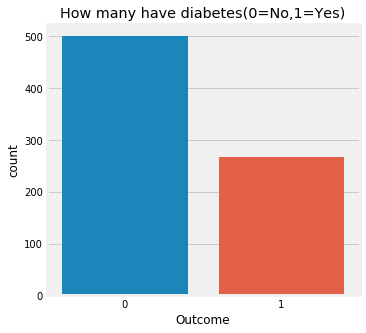

In [7]:
plt.figure(figsize=(5,5))
plt.title('How many have diabetes(0=No,1=Yes)')
locs, labels = plt.xticks()
sns.countplot(data['Outcome'])

In [8]:
data['Outcome'].value_counts()

0    500
1    268
Name: Outcome, dtype: int64

So there are total 500 rows with 0 and 268 with 1,means 268 people is having diabetes in given data.

Lets use now H2O for further Analysis

#### PLOTTING THE HEATMAP IN ORDER TO CHECK THE CORRELATION OF ALL THE INDEPENDENT VARIABLES WITH THE DEPENDENT VARIABLES

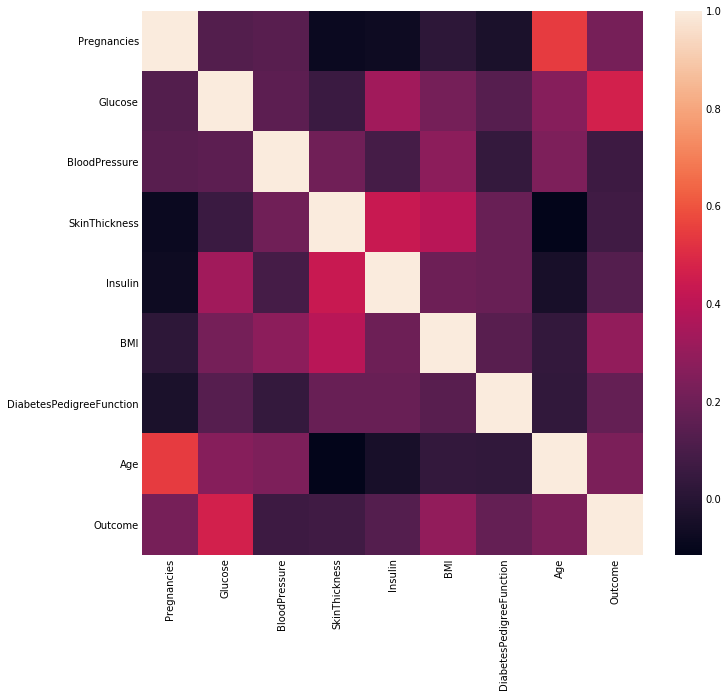

In [72]:
corr = data.corr()
f, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(corr)

From the above plot we can say that BMI and Glucose has high correlation with the Target Outocome

In [9]:
train = pd.read_csv('./diabetes.csv')

In [10]:
train.columns.values

array(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness',
       'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome'],
      dtype=object)

#### CHECKING THE SHAPE OF THE DATA¶


In [11]:
print(train.shape)

(768, 9)


In [12]:
header_train = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness',
       'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome']

In [13]:
training = pd.DataFrame(train)
training.to_csv('training data.csv', columns = header_train, index=False)

#### H2O AUTOML
IMPORTING FILES FOR H2O

In [14]:
training = h2o.import_file("training data.csv")

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [15]:
def alphabet(n):
  alpha='0123456789abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ'    
  str=''
  r=len(alpha)-1   
  while len(str)<n:
    i=random.randint(0,r)
    str+=alpha[i]   
  return str

# storing in m_data dictionary  
def set_meta_data(analysis,run_id,server,data,model_path,run_time,scale,model,balance,balance_threshold,name,path,nthreads,min_mem_size):
  m_data={}
  # m_data['target']=target
  #m_data['classification']=classification
  m_data['project'] =name
  m_data['run_time']=run_time
  m_data['run_id'] =run_id
  m_data['start_time_sec'] = time.time()
  #m_data['min_mem_size'] = min_mem_size
  m_data['balance']=balance
  m_data['balance_threshold']=balance_threshold 
  m_data['max_models']=model
  m_data['scale']=scale  
  m_data['scale']=False
  m_data['model_path']=model_path
  m_data['server_path']=server
  m_data['data_path']=data 
  m_data['run_path'] =path
  m_data['nthreads'] = nthreads
  
  m_data['analysis'] = analysis
  m_data['end_time_sec'] = time.time()  
  return m_data

#### ASSIGNING DATA PARAMETERS, STOPPING PARAMETERS, SOME OPTIONAL PARAMETERS, AND MISCELLANEOUS OPTIONAL PARAMATERS FOR PERFORMING H2O ON THE MODEL¶


In [16]:
target='Outcome' 
data_file='training'
run_id=alphabet(9)# Just some arbitrary ID
server_path=None
classification=True
scale=False
max_models=None
balance_y=False # balance_classes=balance_y
balance_threshold=0.2
project ="automl_test"  # project_name = project
analysis=0
data_path=None
model_path=None
run_time = 500
name=None 
nthreads=1                       
analysis=0
min_mem_size=6
run_dir =None

#### SIMULTANEOUSLY CREATING METADATA


In [17]:
# meta data

meta_data =set_meta_data(analysis, run_id,server_path,data_path,model_path,run_time,scale,max_models,balance_y,balance_threshold,name,run_dir,nthreads,min_mem_size)
print(meta_data)

{'project': None, 'run_time': 500, 'run_id': '22mlstMTq', 'start_time_sec': 1556325881.742752, 'balance': False, 'balance_threshold': 0.2, 'max_models': None, 'scale': False, 'model_path': None, 'server_path': None, 'data_path': None, 'run_path': None, 'nthreads': 1, 'analysis': 0, 'end_time_sec': 1556325881.7427552}


#### PUTTING TARGET VARIABLE IN LABELS


In [18]:
# assign target and inputs
y = target
X = [name for name in training.columns if name != y]
print(y)
print(X)

Outcome
['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']


#### PUTTING ALL THE INDEPENDET VARIABLES IN THE META DATA¶


In [19]:
meta_data['variables']=X

In [20]:
model_start_time = time.time()

In [21]:
aml_500 = H2OAutoML(max_runtime_secs=500,project_name = project) # init automl, run for 500 seconds
aml_500.train(x=X,  
           y=y,
           training_frame=training)

AutoML progress: |████████████████████████████████████████████████████████| 100%


In [22]:
execution_time =  time.time() - model_start_time
meta_data['model_execution_time_sec'] = execution_time
print("Execution time for ", run_time,"sec =  ",meta_data['model_execution_time_sec'])

Execution time for  500 sec =   387.2377588748932


#### LEADERBOARD FOR 500 SECS


In [23]:
leaderboard = aml_500.leaderboard
leaderboard.head(100)


model_id,mean_residual_deviance,rmse,mse,mae,rmsle
StackedEnsemble_BestOfFamily_AutoML_20190426_093335,0.0181554,0.134742,0.0181554,0.0881746,0.0104016
XGBoost_grid_1_AutoML_20190426_094045_model_1,0.0182422,0.135064,0.0182422,0.0904797,0.0104562
XGBoost_3_AutoML_20190426_093335,0.0182696,0.135165,0.0182696,0.0911836,0.0104596
StackedEnsemble_AllModels_AutoML_20190426_093335,0.0182962,0.135263,0.0182962,0.0887608,0.0104478
XGBoost_3_AutoML_20190426_094045,0.0185235,0.136101,0.0185235,0.0920875,0.0105372
XGBoost_grid_1_AutoML_20190426_093335_model_1,0.0186797,0.136674,0.0186797,0.091449,0.0105585
XGBoost_grid_1_AutoML_20190426_094045_model_4,0.0187328,0.136868,0.0187328,0.0922424,0.0106139
XGBoost_2_AutoML_20190426_094045,0.0187523,0.136939,0.0187523,0.0922488,0.0105838
GBM_grid_1_AutoML_20190426_093335_model_5,0.0188484,0.13729,0.0188484,0.0926742,0.0106283
XGBoost_2_AutoML_20190426_093335,0.0188897,0.13744,0.0188897,0.092536,0.0106319


In [24]:
length = len(leaderboard)- 1
length
meta_data["Models_generated"] = length
length

136

#### IMPORTING THE LEADERBOARD AS A LIST¶


In [25]:
# save leaderboard to csv
# run_time = run_time.ascharacter()

aml_500_leaderboard_df=aml_500.leaderboard.as_data_frame()
leaderboard_stats=run_id+'_500_leaderboard.csv'
aml_500_leaderboard_df.to_csv(leaderboard_stats)

In [26]:
#list = leaderboard.as_data_frame(use_pandas=True).as_matrix()[:,0].tolist()
list_500 = leaderboard.as_data_frame(use_pandas=True).as_matrix()[:,0].tolist()

#### GETTING THE TOP MODEL FROM THE LEADERBOARD¶


In [27]:
aml_500leaderboard_df=aml_500.leaderboard.as_data_frame()
model_set=aml_500leaderboard_df['model_id']
mod_best500=h2o.get_model(model_set[1])
mod_best500.algo
mod_best500



Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190426_094045_model_1


ModelMetricsRegression: xgboost
** Reported on train data. **

MSE: 0.004762979970536597
RMSE: 0.06901434612119857
MAE: 0.04684544720061838
RMSLE: 0.005364067334672759
Mean Residual Deviance: 0.004762979970536597

ModelMetricsRegression: xgboost
** Reported on cross-validation data. **

MSE: 0.018242221843269835
RMSE: 0.13506376954338953
MAE: 0.0904796789770257
RMSLE: 0.010456172667320063
Mean Residual Deviance: 0.018242221843269835
Cross-Validation Metrics Summary: 


,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
mae,0.0904797,0.0043823,0.0891737,0.0847483,0.0904850,0.1021434,0.0858481
mean_residual_deviance,0.0182422,0.0037698,0.0171222,0.0142252,0.0176758,0.0284470,0.0137409
mse,0.0182422,0.0037698,0.0171222,0.0142252,0.0176758,0.0284470,0.0137409
r2,0.8870378,0.0167773,0.8985687,0.9037862,0.8846147,0.8420069,0.9062124
residual_deviance,0.0182422,0.0037698,0.0171222,0.0142252,0.0176758,0.0284470,0.0137409
rmse,0.1337911,0.0130797,0.1308519,0.1192694,0.1329503,0.1686625,0.1172215
rmsle,0.0103710,0.0009416,0.0103834,0.0092448,0.0103978,0.0127862,0.0090428


Scoring History: 


,timestamp,duration,number_of_trees,training_rmse,training_mae,training_deviance
,2019-04-26 09:44:47,12.893 sec,0.0,11.5309735,11.5240574,132.9633493
,2019-04-26 09:44:48,12.967 sec,5.0,8.9246109,8.9177382,79.6486798
,2019-04-26 09:44:48,12.990 sec,10.0,6.9084894,6.9015574,47.7272254
,2019-04-26 09:44:48,13.013 sec,15.0,5.3486164,5.3414988,28.6076977
,2019-04-26 09:44:48,13.038 sec,20.0,4.1404998,4.1331078,17.1437387
---,---,---,---,---,---,---
,2019-04-26 09:44:49,14.408 sec,145.0,0.0745232,0.0511383,0.0055537
,2019-04-26 09:44:49,14.485 sec,150.0,0.0732246,0.0502004,0.0053618
,2019-04-26 09:44:49,14.563 sec,155.0,0.0714009,0.0486635,0.0050981
,2019-04-26 09:44:49,14.648 sec,160.0,0.0699430,0.0474999,0.0048920



See the whole table with table.as_data_frame()
Variable Importances: 


variable,relative_importance,scaled_importance,percentage
OverallQual,349.0407410,1.0,0.3298154
GrLivArea,188.3344574,0.5395773,0.1779609
TotalBsmtSF,79.0230026,0.2264005,0.0746704
YearBuilt,62.9582176,0.1803750,0.0594905
GarageCars,51.0034065,0.1461245,0.0481941
---,---,---,---
BldgType_2fmCon,0.0214263,0.0000614,0.0000202
Neighborhood_Timber,0.0188636,0.0000540,0.0000178
Exterior2nd_Stucco,0.0178296,0.0000511,0.0000168
HouseStyle_SFoyer,0.0148542,0.0000426,0.0000140



See the whole table with table.as_data_frame()


In [28]:
mod_best500.params



{'model_id': {'default': None,
  'actual': {'__meta': {'schema_version': 3,
    'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>'},
   'name': 'XGBoost_grid_1_AutoML_20190426_094045_model_1',
   'type': 'Key<Model>',
   'URL': '/3/Models/XGBoost_grid_1_AutoML_20190426_094045_model_1'}},
 'training_frame': {'default': None,
  'actual': {'__meta': {'schema_version': 3,
    'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>'},
   'name': 'automl_training_training_data2.hex',
   'type': 'Key<Frame>',
   'URL': '/3/Frames/automl_training_training_data2.hex'}},
 'validation_frame': {'default': None, 'actual': None},
 'nfolds': {'default': 0, 'actual': 5},
 'keep_cross_validation_models': {'default': True, 'actual': False},
 'keep_cross_validation_predictions': {'default': False, 'actual': True},
 'keep_cross_validation_fold_assignment': {'default': False, 'actual': False},
 'score_each_iteration': {'default': False, 'actual': False},
 'fold_assignment': {'default': 'AUTO'

#### FOR FILE CONVERSION¶


In [29]:
def dict_to_json(dct,n,m):
  j = json.dumps(dct, indent=4)
  f = open(n, m)
  print(j, file=f)
  f.close()
    
def writeToFile(line,n,m):
  f = open(n, m)
  print(line, file=f)
  f.close()
    
def get_stacked_ensemble(lst):
    se=None
    for model in model_set:
      if 'BestOfFamily' in model:
        se=model
    if se is None:     
      for model in model_set:
        if 'AllModels'in model:
          se=model           
    return se      

def get_model_by_algo(algo,models_dict):
    mod=None
    mod_id=None    
    for m in list(models_dict.keys()):
        if m[0:3]==algo:
            mod_id=m
            mod=h2o.get_model(m)      
    return mod,mod_id  

def gbm_stats(modl):
    d={}
    d['algo']=modl.algo
    d['model_id']=modl.model_id   
    d['varimp']=modl.varimp()  
    return d
    
    
def dl_stats(modl):
    d={}
    d['algo']=modl.algo
    d['model_id']=modl.model_id   
    d['varimp']=modl.varimp()  
    return d
    
    
def drf_stats(modl):
    d={}
    d['algo']=modl.algo
    d['model_id']=modl.model_id   
    d['varimp']=modl.varimp()  
    d['roc']=modl.roc()      
    return d
    
def xrt_stats(modl):
    d={}
    d['algo']=modl.algo
    d['model_id']=modl.model_id   
    d['varimp']=modl.varimp()  
    d['roc']=modl.roc()      
    return d
    
    
def glm_stats(modl):
    d={}
    d['algo']=modl.algo
    d['model_id']=modl.model_id   
    d['coef']=modl.coef()  
    d['coef_norm']=modl.coef_norm()      
    return d
def stackedensemble(mod):
    coef_norm=None
    try:
      metalearner = h2o.get_model(mod.metalearner()['name'])
      coef_norm=metalearner.coef_norm()
    except:
      pass        
    return coef_norm

def stackedensemble_df(df):
    bm_algo={ 'GBM': None,'GLM': None,'DRF': None,'XRT': None,'Dee': None}
    for index, row in df.iterrows():
      if len(row['model_id'])>3:
        key=row['model_id'][0:3]
        if key in bm_algo:
          if bm_algo[key] is None:
                bm_algo[key]=row['model_id']
    bm=list(bm_algo.values()) 
    bm=list(filter(None.__ne__, bm))             
    return bm


#### A FUNCTION FOR GENERATING HYPERPARAMETERS FOR EVERY MODEL IN THE LEADER BOARD BY PASSING THE MODEL AND AN ARRAY OF HYPERPARAMETERS ALONG WITH THE RUN TIME AND THE LIST RUNTIME

In [30]:
def generate_hyperparameters(model, keys, run_time, list_runtime):
    list = list_runtime;
    head = "Model Name,"
    for k in keys:
        head = head + k+"_default"+","+ k+"_actual"+","
    head = head[:-1]
   # n1=run_id+'_hy_parameter_500_XGBoost.csv'
    n1=run_id+'_hy_parameter_'+run_time+'_'+model+'.csv';
    writeToFile(head,n1,'w')

    for algo in list:
        if algo.startswith(model):
           # print(algo)
            mod = h2o.get_model(algo)
            hy_parameter_500 = mod.params
            n=run_id+'_hy_parameter_'+run_time+'_'+model+'.json';
            dict_to_json(hy_parameter_500,n,'a')
            mod.params

            rec=algo+","
            for k in keys:
                print(mod.params[k])
                rec = rec + str(mod.params[k]["default"])+","+str(mod.params[k]["actual"])+","
            rec = rec[:-1]
            print(rec)
            writeToFile(rec,n1,'a')


####  For Run_Time = 500 SPECIFYING THE HYPERPARAMETERS AND THE MODEL NAMES AND PASSING THEM THROUGH THE GENERATE HYPERPARAMETERS FUNCTION

In [31]:
keys_xgboost = ["ntrees","max_depth","min_rows","min_sum_hessian_in_leaf","sample_rate","col_sample_rate","col_sample_rate_per_tree","booster","reg_lambda","reg_alpha"];
keys_gbm = ["histogram_type","ntrees","max_depth","min_rows","learn_rate","sample_rate","col_sample_rate","col_sample_rate_per_tree","min_split_improvement"];
keys_glm = ["alpha","missing_values_handling"];
keys_dl = ["epochs","activation","rho","epsilon","input_dropout_ratio","hidden","hidden_dropout_ratios"];


generate_hyperparameters('XGBoost',keys_xgboost,'500', list_500);
generate_hyperparameters('GBM',keys_gbm, '500', list_500);
generate_hyperparameters('GLM',keys_glm, '500', list_500);
generate_hyperparameters('DeepLearning',keys_dl, '500', list_500);

{'default': 50, 'actual': 163}
{'default': 6, 'actual': 10}
{'default': 1.0, 'actual': 10.0}
{'default': 100.0, 'actual': 100.0}
{'default': 1.0, 'actual': 0.6}
{'default': 1.0, 'actual': 0.8}
{'default': 1.0, 'actual': 0.7}
{'default': 'gbtree', 'actual': 'gbtree'}
{'default': 1.0, 'actual': 0.1}
{'default': 0.0, 'actual': 0.01}
XGBoost_grid_1_AutoML_20190426_094045_model_1,50,163,6,10,1.0,10.0,100.0,100.0,1.0,0.6,1.0,0.8,1.0,0.7,gbtree,gbtree,1.0,0.1,0.0,0.01
{'default': 50, 'actual': 150}
{'default': 6, 'actual': 20}
{'default': 1.0, 'actual': 10.0}
{'default': 100.0, 'actual': 100.0}
{'default': 1.0, 'actual': 0.6}
{'default': 1.0, 'actual': 0.8}
{'default': 1.0, 'actual': 0.8}
{'default': 'gbtree', 'actual': 'gbtree'}
{'default': 1.0, 'actual': 1.0}
{'default': 0.0, 'actual': 0.0}
XGBoost_3_AutoML_20190426_093335,50,150,6,20,1.0,10.0,100.0,100.0,1.0,0.6,1.0,0.8,1.0,0.8,gbtree,gbtree,1.0,1.0,0.0,0.0
{'default': 50, 'actual': 147}
{'default': 6, 'actual': 20}
{'default': 1.0, 'actua

XGBoost_1_AutoML_20190426_203923,50,44,6,20,1.0,10.0,100.0,100.0,1.0,0.6,1.0,0.8,1.0,0.8,gbtree,gbtree,1.0,1.0,0.0,0.0
{'default': 50, 'actual': 69}
{'default': 6, 'actual': 5}
{'default': 1.0, 'actual': 15.0}
{'default': 100.0, 'actual': 100.0}
{'default': 1.0, 'actual': 0.8}
{'default': 1.0, 'actual': 0.8}
{'default': 1.0, 'actual': 0.7}
{'default': 'gbtree', 'actual': 'gbtree'}
{'default': 1.0, 'actual': 10.0}
{'default': 0.0, 'actual': 0.001}
XGBoost_grid_1_AutoML_20190426_203923_model_3,50,69,6,5,1.0,15.0,100.0,100.0,1.0,0.8,1.0,0.8,1.0,0.7,gbtree,gbtree,1.0,10.0,0.0,0.001
{'default': 50, 'actual': 92}
{'default': 6, 'actual': 15}
{'default': 1.0, 'actual': 1.0}
{'default': 100.0, 'actual': 100.0}
{'default': 1.0, 'actual': 0.6}
{'default': 1.0, 'actual': 0.6}
{'default': 1.0, 'actual': 0.9}
{'default': 'gbtree', 'actual': 'gbtree'}
{'default': 1.0, 'actual': 100.0}
{'default': 0.0, 'actual': 0.5}
XGBoost_grid_1_AutoML_20190426_204449_model_5,50,92,6,15,1.0,1.0,100.0,100.0,1.0,0.6

{'default': 1.0, 'actual': 1.0}
{'default': 0.0, 'actual': 0.5}
XGBoost_grid_1_AutoML_20190426_203923_model_7,50,77,6,15,1.0,15.0,100.0,100.0,1.0,1.0,1.0,0.8,1.0,0.7,gbtree,dart,1.0,1.0,0.0,0.5
{'default': 50, 'actual': 103}
{'default': 6, 'actual': 10}
{'default': 1.0, 'actual': 5.0}
{'default': 100.0, 'actual': 100.0}
{'default': 1.0, 'actual': 0.8}
{'default': 1.0, 'actual': 0.8}
{'default': 1.0, 'actual': 0.9}
{'default': 'gbtree', 'actual': 'dart'}
{'default': 1.0, 'actual': 0.001}
{'default': 0.0, 'actual': 0.5}
XGBoost_grid_1_AutoML_20190426_093335_model_3,50,103,6,10,1.0,5.0,100.0,100.0,1.0,0.8,1.0,0.8,1.0,0.9,gbtree,dart,1.0,0.001,0.0,0.5
{'default': 50, 'actual': 99}
{'default': 6, 'actual': 15}
{'default': 1.0, 'actual': 20.0}
{'default': 100.0, 'actual': 100.0}
{'default': 1.0, 'actual': 0.8}
{'default': 1.0, 'actual': 0.8}
{'default': 1.0, 'actual': 1.0}
{'default': 'gbtree', 'actual': 'dart'}
{'default': 1.0, 'actual': 0.1}
{'default': 0.0, 'actual': 0.01}
XGBoost_grid_1_

{'default': 0.1, 'actual': 0.008}
{'default': 1.0, 'actual': 0.6}
{'default': 1.0, 'actual': 0.7}
{'default': 1.0, 'actual': 0.4}
{'default': 1e-05, 'actual': 0.0001}
GBM_grid_1_AutoML_20190426_094045_model_2,AUTO,AUTO,50,13,5,3,10.0,10.0,0.1,0.008,1.0,0.6,1.0,0.7,1.0,0.4,1e-05,0.0001
{'default': 'AUTO', 'actual': 'AUTO'}
{'default': 50, 'actual': 30}
{'default': 5, 'actual': 12}
{'default': 10.0, 'actual': 100.0}
{'default': 0.1, 'actual': 0.001}
{'default': 1.0, 'actual': 0.8}
{'default': 1.0, 'actual': 0.7}
{'default': 1.0, 'actual': 0.4}
{'default': 1e-05, 'actual': 1e-05}
GBM_grid_1_AutoML_20190426_093335_model_3,AUTO,AUTO,50,30,5,12,10.0,100.0,0.1,0.001,1.0,0.8,1.0,0.7,1.0,0.4,1e-05,1e-05
{'default': 'AUTO', 'actual': 'AUTO'}
{'default': 50, 'actual': 1}
{'default': 5, 'actual': 13}
{'default': 10.0, 'actual': 1.0}
{'default': 0.1, 'actual': 0.01}
{'default': 1.0, 'actual': 0.7}
{'default': 1.0, 'actual': 1.0}
{'default': 1.0, 'actual': 0.4}
{'default': 1e-05, 'actual': 0.0001}
G

{'default': 0.1, 'actual': 0.1}
{'default': 1.0, 'actual': 0.8}
{'default': 1.0, 'actual': 0.8}
{'default': 1.0, 'actual': 0.8}
{'default': 1e-05, 'actual': 1e-05}
GBM_1_AutoML_20190426_204449,AUTO,AUTO,50,31,5,15,10.0,100.0,0.1,0.1,1.0,0.8,1.0,0.8,1.0,0.8,1e-05,1e-05
{'default': 'AUTO', 'actual': 'AUTO'}
{'default': 50, 'actual': 52}
{'default': 5, 'actual': 10}
{'default': 10.0, 'actual': 15.0}
{'default': 0.1, 'actual': 0.05}
{'default': 1.0, 'actual': 0.9}
{'default': 1.0, 'actual': 0.7}
{'default': 1.0, 'actual': 0.4}
{'default': 1e-05, 'actual': 0.0001}
GBM_grid_1_AutoML_20190426_203923_model_1,AUTO,AUTO,50,52,5,10,10.0,15.0,0.1,0.05,1.0,0.9,1.0,0.7,1.0,0.4,1e-05,0.0001
{'default': 'AUTO', 'actual': 'AUTO'}
{'default': 50, 'actual': 42}
{'default': 5, 'actual': 11}
{'default': 10.0, 'actual': 5.0}
{'default': 0.1, 'actual': 0.05}
{'default': 1.0, 'actual': 1.0}
{'default': 1.0, 'actual': 1.0}
{'default': 1.0, 'actual': 0.7}
{'default': 1e-05, 'actual': 1e-05}
GBM_grid_1_AutoML_20

{'default': 50, 'actual': 46}
{'default': 5, 'actual': 11}
{'default': 10.0, 'actual': 30.0}
{'default': 0.1, 'actual': 0.005}
{'default': 1.0, 'actual': 1.0}
{'default': 1.0, 'actual': 0.7}
{'default': 1.0, 'actual': 1.0}
{'default': 1e-05, 'actual': 1e-05}
GBM_grid_1_AutoML_20190426_203923_model_14,AUTO,AUTO,50,46,5,11,10.0,30.0,0.1,0.005,1.0,1.0,1.0,0.7,1.0,1.0,1e-05,1e-05
{'default': 'AUTO', 'actual': 'AUTO'}
{'default': 50, 'actual': 40}
{'default': 5, 'actual': 4}
{'default': 10.0, 'actual': 100.0}
{'default': 0.1, 'actual': 0.008}
{'default': 1.0, 'actual': 0.8}
{'default': 1.0, 'actual': 0.7}
{'default': 1.0, 'actual': 0.7}
{'default': 1e-05, 'actual': 1e-05}
GBM_grid_1_AutoML_20190426_203923_model_13,AUTO,AUTO,50,40,5,4,10.0,100.0,0.1,0.008,1.0,0.8,1.0,0.7,1.0,0.7,1e-05,1e-05
{'default': 'AUTO', 'actual': 'AUTO'}
{'default': 50, 'actual': 35}
{'default': 5, 'actual': 14}
{'default': 10.0, 'actual': 15.0}
{'default': 0.1, 'actual': 0.005}
{'default': 1.0, 'actual': 0.7}
{'defau

{'default': 1e-08, 'actual': 1e-07}
{'default': 0.0, 'actual': 0.0}
{'default': [200, 200], 'actual': [200]}
{'default': None, 'actual': [0.0]}
DeepLearning_grid_1_AutoML_20190426_094045_model_1,10.0,8.0,Rectifier,RectifierWithDropout,0.99,0.95,1e-08,1e-07,0.0,0.0,[200, 200],[200],None,[0.0]
{'default': 10.0, 'actual': 3.041095890410959}
{'default': 'Rectifier', 'actual': 'RectifierWithDropout'}
{'default': 0.99, 'actual': 0.99}
{'default': 1e-08, 'actual': 1e-06}
{'default': 0.0, 'actual': 0.15}
{'default': [200, 200], 'actual': [500, 500, 500]}
{'default': None, 'actual': [0.0, 0.0, 0.0]}
DeepLearning_grid_1_AutoML_20190426_093335_model_3,10.0,3.041095890410959,Rectifier,RectifierWithDropout,0.99,0.99,1e-08,1e-06,0.0,0.15,[200, 200],[500, 500, 500],None,[0.0, 0.0, 0.0]
{'default': 10.0, 'actual': 8921.888780487807}
{'default': 'Rectifier', 'actual': 'RectifierWithDropout'}
{'default': 0.99, 'actual': 0.99}
{'default': 1e-08, 'actual': 1e-08}
{'default': 0.0, 'actual': 0.05}
{'default

In [32]:
meta_data['end_time'] = time.time()

In [33]:
meta_data

{'project': None,
 'run_time': 500,
 'run_id': '22mlstMTq',
 'start_time_sec': 1556325881.742752,
 'balance': False,
 'balance_threshold': 0.2,
 'max_models': None,
 'scale': False,
 'model_path': None,
 'server_path': None,
 'data_path': None,
 'run_path': None,
 'nthreads': 1,
 'analysis': 0,
 'end_time_sec': 1556325881.7427552,
 'variables': ['Pregnancies',
  'Glucose',
  'BloodPressure',
  'SkinThickness',
  'Insulin',
  'BMI',
  'DiabetesPedigreeFunction',
  'Age'],
 'model_execution_time_sec': 387.2377588748932,
 'Models_generated': 136,
 'end_time': 1556326631.685162}

In [34]:
n=run_id+'_500_meta_data.json'
dict_to_json(meta_data,n,'a')

In [36]:
run_time = 1000
meta_data =set_meta_data(analysis, run_id,server_path,data_path,model_path,run_time,scale,max_models,balance_y,balance_threshold,name,run_dir,nthreads,min_mem_size)
print(meta_data)

{'project': None, 'run_time': 1000, 'run_id': '22mlstMTq', 'start_time_sec': 1556326747.976606, 'balance': False, 'balance_threshold': 0.2, 'max_models': None, 'scale': False, 'model_path': None, 'server_path': None, 'data_path': None, 'run_path': None, 'nthreads': 1, 'analysis': 0, 'end_time_sec': 1556326747.976608}


In [37]:
meta_data['variables']=X

model_start_time = time.time()

In [38]:
aml_1000 = H2OAutoML(max_runtime_secs=1000,project_name = project) # init automl, run for 1000 seconds
aml_1000.train(x=X,  
           y=y,
           training_frame=training)

AutoML progress: |████████████████████████████████████████████████████████| 100%


In [39]:
execution_time =  time.time() - model_start_time
meta_data['model_execution_time_sec'] = execution_time
print("Execution time for ", run_time,"sec =  ",meta_data['model_execution_time_sec'])

Execution time for  1000 sec =   1004.6652631759644


In [41]:
meta_data['variables']=X

model_start_time = time.time()

#### Leaderboard for 1000 sec

In [42]:
leaderboard_1000 = aml_1000.leaderboard
leaderboard_1000.head(50)

model_id,mean_residual_deviance,rmse,mse,mae,rmsle
StackedEnsemble_BestOfFamily_AutoML_20190426_093335,0.0181554,0.134742,0.0181554,0.0881746,0.0104016
XGBoost_grid_1_AutoML_20190426_094045_model_1,0.0182422,0.135064,0.0182422,0.0904797,0.0104562
XGBoost_3_AutoML_20190426_093335,0.0182696,0.135165,0.0182696,0.0911836,0.0104596
StackedEnsemble_AllModels_AutoML_20190426_093335,0.0182962,0.135263,0.0182962,0.0887608,0.0104478
XGBoost_3_AutoML_20190426_094045,0.0185235,0.136101,0.0185235,0.0920875,0.0105372
XGBoost_grid_1_AutoML_20190426_093335_model_1,0.0186797,0.136674,0.0186797,0.091449,0.0105585
XGBoost_grid_1_AutoML_20190426_094045_model_4,0.0187328,0.136868,0.0187328,0.0922424,0.0106139
XGBoost_2_AutoML_20190426_094045,0.0187523,0.136939,0.0187523,0.0922488,0.0105838
GBM_grid_1_AutoML_20190426_093335_model_5,0.0188484,0.13729,0.0188484,0.0926742,0.0106283
XGBoost_2_AutoML_20190426_093335,0.0188897,0.13744,0.0188897,0.092536,0.0106319


In [43]:
length = len(leaderboard_1000)- 1
length
meta_data["Models_generated"] = length
length

198

In [44]:
# save leaderboard to csv
# run_time = run_time.ascharacter()

aml_1000_leaderboard_df=aml_1000.leaderboard.as_data_frame()
leaderboard_stats=run_id+'_1000_leaderboard.csv'
aml_1000_leaderboard_df.to_csv(leaderboard_stats)

In [45]:
aml_1000leaderboard_df=aml_1000.leaderboard.as_data_frame()
model_set=aml_1000leaderboard_df['model_id']
mod_best1000=h2o.get_model(model_set[0])

In [46]:
mod_best1000.params



{'model_id': {'default': None,
  'actual': {'__meta': {'schema_version': 3,
    'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>'},
   'name': 'StackedEnsemble_BestOfFamily_AutoML_20190426_093335',
   'type': 'Key<Model>',
   'URL': '/3/Models/StackedEnsemble_BestOfFamily_AutoML_20190426_093335'}},
 'training_frame': {'default': None,
  'actual': {'__meta': {'schema_version': 3,
    'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>'},
   'name': 'automl_training_training_data1.hex',
   'type': 'Key<Frame>',
   'URL': '/3/Frames/automl_training_training_data1.hex'}},
 'response_column': {'default': None,
  'actual': {'__meta': {'schema_version': 3,
    'schema_name': 'ColSpecifierV3',
    'schema_type': 'VecSpecifier'},
   'column_name': 'SalePrice',
   'is_member_of_frames': None}},
 'validation_frame': {'default': None, 'actual': None},
 'base_models': {'default': [],
  'actual': [{'__meta': {'schema_version': 3,
     'schema_name': 'ModelKeyV3',
     'schema_type

In [47]:
list_1000 = leaderboard_1000.as_data_frame(use_pandas=True).as_matrix()[:,0].tolist()


####  For Run_Time = 1000 sec SPECIFYING THE HYPERPARAMETERS AND THE MODEL NAMES AND PASSING THEM THROUGH THE GENERATE HYPERPARAMETERS FUNCTION

In [48]:
'''
keys_xgboost = ["ntrees","max_depth","min_rows","min_sum_hessian_in_leaf","sample_rate","col_sample_rate","col_sample_rate_per_tree","booster","reg_lambda","reg_alpha"];
keys_gbm = ["histogram_type","ntrees","max_depth","min_rows","learn_rate","sample_rate","col_sample_rate","col_sample_rate_per_tree","min_split_improvement"];
keys_glm = ["alpha","missing_values_handling"];
keys_dl = ["epochs","activation","rho","epsilon","input_dropout_ratio","hidden","hidden_dropout_ratios"];
'''

generate_hyperparameters('XGBoost',keys_xgboost,'1000', list_1000);
generate_hyperparameters('GBM',keys_gbm, '1000', list_1000);
generate_hyperparameters('GLM',keys_glm, '1000', list_1000);
generate_hyperparameters('DeepLearning',keys_dl, '1000', list_1000);

{'default': 50, 'actual': 163}
{'default': 6, 'actual': 10}
{'default': 1.0, 'actual': 10.0}
{'default': 100.0, 'actual': 100.0}
{'default': 1.0, 'actual': 0.6}
{'default': 1.0, 'actual': 0.8}
{'default': 1.0, 'actual': 0.7}
{'default': 1.0, 'actual': 0.1}
{'default': 0.0, 'actual': 0.01}
XGBoost_grid_1_AutoML_20190426_094045_model_1,50,163,6,10,1.0,10.0,100.0,100.0,1.0,0.6,1.0,0.8,1.0,0.7,1.0,0.1,0.0,0.01
{'default': 50, 'actual': 150}
{'default': 6, 'actual': 20}
{'default': 1.0, 'actual': 10.0}
{'default': 100.0, 'actual': 100.0}
{'default': 1.0, 'actual': 0.6}
{'default': 1.0, 'actual': 0.8}
{'default': 1.0, 'actual': 0.8}
{'default': 1.0, 'actual': 1.0}
{'default': 0.0, 'actual': 0.0}
XGBoost_3_AutoML_20190426_093335,50,150,6,20,1.0,10.0,100.0,100.0,1.0,0.6,1.0,0.8,1.0,0.8,1.0,1.0,0.0,0.0
{'default': 50, 'actual': 147}
{'default': 6, 'actual': 20}
{'default': 1.0, 'actual': 10.0}
{'default': 100.0, 'actual': 100.0}
{'default': 1.0, 'actual': 0.6}
{'default': 1.0, 'actual': 0.8}
{'

{'default': 100.0, 'actual': 100.0}
{'default': 1.0, 'actual': 0.8}
{'default': 1.0, 'actual': 0.8}
{'default': 1.0, 'actual': 0.7}
{'default': 1.0, 'actual': 10.0}
{'default': 0.0, 'actual': 0.001}
XGBoost_grid_1_AutoML_20190426_203923_model_3,50,69,6,5,1.0,15.0,100.0,100.0,1.0,0.8,1.0,0.8,1.0,0.7,1.0,10.0,0.0,0.001
{'default': 50, 'actual': 92}
{'default': 6, 'actual': 15}
{'default': 1.0, 'actual': 1.0}
{'default': 100.0, 'actual': 100.0}
{'default': 1.0, 'actual': 0.6}
{'default': 1.0, 'actual': 0.6}
{'default': 1.0, 'actual': 0.9}
{'default': 1.0, 'actual': 100.0}
{'default': 0.0, 'actual': 0.5}
XGBoost_grid_1_AutoML_20190426_204449_model_5,50,92,6,15,1.0,1.0,100.0,100.0,1.0,0.6,1.0,0.6,1.0,0.9,1.0,100.0,0.0,0.5
{'default': 50, 'actual': 88}
{'default': 6, 'actual': 20}
{'default': 1.0, 'actual': 0.01}
{'default': 100.0, 'actual': 100.0}
{'default': 1.0, 'actual': 0.8}
{'default': 1.0, 'actual': 0.6}
{'default': 1.0, 'actual': 0.8}
{'default': 1.0, 'actual': 100.0}
{'default': 0.0

{'default': 1.0, 'actual': 10.0}
{'default': 0.0, 'actual': 0.1}
XGBoost_grid_1_AutoML_20190426_210356_model_2,50,64,6,20,1.0,1.0,100.0,100.0,1.0,1.0,1.0,1.0,1.0,0.9,1.0,10.0,0.0,0.1
{'default': 50, 'actual': 60}
{'default': 6, 'actual': 20}
{'default': 1.0, 'actual': 3.0}
{'default': 100.0, 'actual': 100.0}
{'default': 1.0, 'actual': 0.8}
{'default': 1.0, 'actual': 0.8}
{'default': 1.0, 'actual': 0.9}
{'default': 1.0, 'actual': 0.1}
{'default': 0.0, 'actual': 0.001}
XGBoost_grid_1_AutoML_20190426_204449_model_2,50,60,6,20,1.0,3.0,100.0,100.0,1.0,0.8,1.0,0.8,1.0,0.9,1.0,0.1,0.0,0.001
{'default': 50, 'actual': 59}
{'default': 6, 'actual': 10}
{'default': 1.0, 'actual': 0.01}
{'default': 100.0, 'actual': 100.0}
{'default': 1.0, 'actual': 0.8}
{'default': 1.0, 'actual': 1.0}
{'default': 1.0, 'actual': 1.0}
{'default': 1.0, 'actual': 0.1}
{'default': 0.0, 'actual': 0.1}
XGBoost_grid_1_AutoML_20190426_210356_model_3,50,59,6,10,1.0,0.01,100.0,100.0,1.0,0.8,1.0,1.0,1.0,1.0,1.0,0.1,0.0,0.1
{'d

GBM_3_AutoML_20190426_094045,AUTO,AUTO,50,54,5,15,10.0,100.0,0.1,0.1,1.0,0.8,1.0,0.8,1.0,0.8,1e-05,1e-05
{'default': 'AUTO', 'actual': 'AUTO'}
{'default': 50, 'actual': 63}
{'default': 5, 'actual': 9}
{'default': 10.0, 'actual': 1.0}
{'default': 0.1, 'actual': 0.1}
{'default': 1.0, 'actual': 0.6}
{'default': 1.0, 'actual': 1.0}
{'default': 1.0, 'actual': 0.4}
{'default': 1e-05, 'actual': 1e-05}
GBM_grid_1_AutoML_20190426_093335_model_4,AUTO,AUTO,50,63,5,9,10.0,1.0,0.1,0.1,1.0,0.6,1.0,1.0,1.0,0.4,1e-05,1e-05
{'default': 'AUTO', 'actual': 'AUTO'}
{'default': 50, 'actual': 54}
{'default': 5, 'actual': 15}
{'default': 10.0, 'actual': 100.0}
{'default': 0.1, 'actual': 0.1}
{'default': 1.0, 'actual': 0.8}
{'default': 1.0, 'actual': 0.8}
{'default': 1.0, 'actual': 0.8}
{'default': 1e-05, 'actual': 1e-05}
GBM_5_AutoML_20190426_094045,AUTO,AUTO,50,54,5,15,10.0,100.0,0.1,0.1,1.0,0.8,1.0,0.8,1.0,0.8,1e-05,1e-05
{'default': 'AUTO', 'actual': 'AUTO'}
{'default': 50, 'actual': 54}
{'default': 5, 'ac

{'default': 1e-05, 'actual': 1e-05}
GBM_3_AutoML_20190426_203923,AUTO,AUTO,50,31,5,15,10.0,100.0,0.1,0.1,1.0,0.8,1.0,0.8,1.0,0.8,1e-05,1e-05
{'default': 'AUTO', 'actual': 'AUTO'}
{'default': 50, 'actual': 31}
{'default': 5, 'actual': 15}
{'default': 10.0, 'actual': 100.0}
{'default': 0.1, 'actual': 0.1}
{'default': 1.0, 'actual': 0.8}
{'default': 1.0, 'actual': 0.8}
{'default': 1.0, 'actual': 0.8}
{'default': 1e-05, 'actual': 1e-05}
GBM_4_AutoML_20190426_204449,AUTO,AUTO,50,31,5,15,10.0,100.0,0.1,0.1,1.0,0.8,1.0,0.8,1.0,0.8,1e-05,1e-05
{'default': 'AUTO', 'actual': 'AUTO'}
{'default': 50, 'actual': 39}
{'default': 5, 'actual': 16}
{'default': 10.0, 'actual': 10.0}
{'default': 0.1, 'actual': 0.08}
{'default': 1.0, 'actual': 0.6}
{'default': 1.0, 'actual': 0.7}
{'default': 1.0, 'actual': 0.7}
{'default': 1e-05, 'actual': 1e-05}
GBM_grid_1_AutoML_20190426_204449_model_9,AUTO,AUTO,50,39,5,16,10.0,10.0,0.1,0.08,1.0,0.6,1.0,0.7,1.0,0.7,1e-05,1e-05
{'default': 'AUTO', 'actual': 'AUTO'}
{'defa

GBM_grid_1_AutoML_20190426_210356_model_30,AUTO,AUTO,50,43,5,15,10.0,10.0,0.1,0.08,1.0,0.6,1.0,1.0,1.0,0.4,1e-05,1e-05
{'default': 'AUTO', 'actual': 'AUTO'}
{'default': 50, 'actual': 33}
{'default': 5, 'actual': 7}
{'default': 10.0, 'actual': 5.0}
{'default': 0.1, 'actual': 0.08}
{'default': 1.0, 'actual': 1.0}
{'default': 1.0, 'actual': 1.0}
{'default': 1.0, 'actual': 1.0}
{'default': 1e-05, 'actual': 0.0001}
GBM_grid_1_AutoML_20190426_210356_model_29,AUTO,AUTO,50,33,5,7,10.0,5.0,0.1,0.08,1.0,1.0,1.0,1.0,1.0,1.0,1e-05,0.0001
{'default': 'AUTO', 'actual': 'AUTO'}
{'default': 50, 'actual': 70}
{'default': 5, 'actual': 12}
{'default': 10.0, 'actual': 5.0}
{'default': 0.1, 'actual': 0.01}
{'default': 1.0, 'actual': 0.6}
{'default': 1.0, 'actual': 1.0}
{'default': 1.0, 'actual': 1.0}
{'default': 1e-05, 'actual': 0.0001}
GBM_grid_1_AutoML_20190426_210356_model_23,AUTO,AUTO,50,70,5,12,10.0,5.0,0.1,0.01,1.0,0.6,1.0,1.0,1.0,1.0,1e-05,0.0001
{'default': 'AUTO', 'actual': 'AUTO'}
{'default': 50,

{'default': 1.0, 'actual': 1.0}
{'default': 1.0, 'actual': 0.4}
{'default': 1e-05, 'actual': 1e-05}
GBM_grid_1_AutoML_20190426_210356_model_6,AUTO,AUTO,50,63,5,8,10.0,10.0,0.1,0.01,1.0,0.6,1.0,1.0,1.0,0.4,1e-05,1e-05
{'default': 'AUTO', 'actual': 'AUTO'}
{'default': 50, 'actual': 61}
{'default': 5, 'actual': 3}
{'default': 10.0, 'actual': 30.0}
{'default': 0.1, 'actual': 0.008}
{'default': 1.0, 'actual': 1.0}
{'default': 1.0, 'actual': 0.7}
{'default': 1.0, 'actual': 1.0}
{'default': 1e-05, 'actual': 1e-05}
GBM_grid_1_AutoML_20190426_204449_model_4,AUTO,AUTO,50,61,5,3,10.0,30.0,0.1,0.008,1.0,1.0,1.0,0.7,1.0,1.0,1e-05,1e-05
{'default': 'AUTO', 'actual': 'AUTO'}
{'default': 50, 'actual': 60}
{'default': 5, 'actual': 11}
{'default': 10.0, 'actual': 15.0}
{'default': 0.1, 'actual': 0.01}
{'default': 1.0, 'actual': 0.6}
{'default': 1.0, 'actual': 0.7}
{'default': 1.0, 'actual': 0.4}
{'default': 1e-05, 'actual': 1e-05}
GBM_grid_1_AutoML_20190426_203923_model_17,AUTO,AUTO,50,60,5,11,10.0,15.0

{'default': 5, 'actual': 11}
{'default': 10.0, 'actual': 5.0}
{'default': 0.1, 'actual': 0.001}
{'default': 1.0, 'actual': 0.8}
{'default': 1.0, 'actual': 0.7}
{'default': 1.0, 'actual': 1.0}
{'default': 1e-05, 'actual': 1e-05}
GBM_grid_1_AutoML_20190426_210356_model_13,AUTO,AUTO,50,30,5,11,10.0,5.0,0.1,0.001,1.0,0.8,1.0,0.7,1.0,1.0,1e-05,1e-05
{'default': 'AUTO', 'actual': 'AUTO'}
{'default': 50, 'actual': 30}
{'default': 5, 'actual': 15}
{'default': 10.0, 'actual': 5.0}
{'default': 0.1, 'actual': 0.001}
{'default': 1.0, 'actual': 0.6}
{'default': 1.0, 'actual': 0.7}
{'default': 1.0, 'actual': 1.0}
{'default': 1e-05, 'actual': 1e-05}
GBM_grid_1_AutoML_20190426_210356_model_12,AUTO,AUTO,50,30,5,15,10.0,5.0,0.1,0.001,1.0,0.6,1.0,0.7,1.0,1.0,1e-05,1e-05
{'default': 'AUTO', 'actual': 'AUTO'}
{'default': 50, 'actual': 30}
{'default': 5, 'actual': 12}
{'default': 10.0, 'actual': 15.0}
{'default': 0.1, 'actual': 0.001}
{'default': 1.0, 'actual': 0.5}
{'default': 1.0, 'actual': 1.0}
{'default

GLM_grid_1_AutoML_20190426_203923_model_1,None,[0.0, 0.2, 0.4, 0.6, 0.8, 1.0],MeanImputation,MeanImputation
{'default': None, 'actual': [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]}
{'default': 'MeanImputation', 'actual': 'MeanImputation'}
GLM_grid_1_AutoML_20190426_204449_model_1,None,[0.0, 0.2, 0.4, 0.6, 0.8, 1.0],MeanImputation,MeanImputation
{'default': 10.0, 'actual': 8.0}
{'default': 'Rectifier', 'actual': 'RectifierWithDropout'}
{'default': 0.99, 'actual': 0.99}
{'default': 1e-08, 'actual': 1e-07}
{'default': 0.0, 'actual': 0.05}
{'default': [200, 200], 'actual': [200, 200]}
{'default': None, 'actual': [0.2, 0.2]}
DeepLearning_grid_1_AutoML_20190426_093335_model_2,10.0,8.0,Rectifier,RectifierWithDropout,0.99,0.99,1e-08,1e-07,0.0,0.05,[200, 200],[200, 200],None,[0.2, 0.2]
{'default': 10.0, 'actual': 8.0}
{'default': 'Rectifier', 'actual': 'RectifierWithDropout'}
{'default': 0.99, 'actual': 0.99}
{'default': 1e-08, 'actual': 1e-07}
{'default': 0.0, 'actual': 0.2}
{'default': [200, 200], 'actual

{'default': [200, 200], 'actual': [10, 10, 10]}
{'default': None, 'actual': None}
DeepLearning_1_AutoML_20190426_204449,10.0,10.421555573210455,Rectifier,Rectifier,0.99,0.99,1e-08,1e-08,0.0,0.0,[200, 200],[10, 10, 10],None,None
{'default': 10.0, 'actual': 214.40585365853659}
{'default': 'Rectifier', 'actual': 'RectifierWithDropout'}
{'default': 0.99, 'actual': 0.9}
{'default': 1e-08, 'actual': 1e-06}
{'default': 0.0, 'actual': 0.2}
{'default': [200, 200], 'actual': [500, 500]}
{'default': None, 'actual': [0.5, 0.5]}
DeepLearning_grid_1_AutoML_20190426_203923_model_2,10.0,214.40585365853659,Rectifier,RectifierWithDropout,0.99,0.9,1e-08,1e-06,0.0,0.2,[200, 200],[500, 500],None,[0.5, 0.5]
{'default': 10.0, 'actual': 60.82276422764228}
{'default': 'Rectifier', 'actual': 'RectifierWithDropout'}
{'default': 0.99, 'actual': 0.9}
{'default': 1e-08, 'actual': 1e-06}
{'default': 0.0, 'actual': 0.15}
{'default': [200, 200], 'actual': [500, 500, 500]}
{'default': None, 'actual': [0.4, 0.4, 0.4]}
D

In [49]:
meta_data['end_time'] = time.time()



In [50]:
n=run_id+'_1000_meta_data.json'
dict_to_json(meta_data,n,'a')

In [51]:
run_time = 1500
meta_data =set_meta_data(analysis, run_id,server_path,data_path,model_path,run_time,scale,max_models,balance_y,balance_threshold,name,run_dir,nthreads,min_mem_size)
print(meta_data)

{'project': None, 'run_time': 1500, 'run_id': '22mlstMTq', 'start_time_sec': 1556328144.860515, 'balance': False, 'balance_threshold': 0.2, 'max_models': None, 'scale': False, 'model_path': None, 'server_path': None, 'data_path': None, 'run_path': None, 'nthreads': 1, 'analysis': 0, 'end_time_sec': 1556328144.860518}


In [52]:
meta_data['variables']=X

model_start_time = time.time()

In [53]:
aml_1500 = H2OAutoML(max_runtime_secs=1500,project_name = project) # init automl, run for 1500 seconds
aml_1500.train(x=X,  
           y=y,
           training_frame=training)

AutoML progress: |████████████████████████████████████████████████████████| 100%


In [54]:
execution_time =  time.time() - model_start_time
meta_data['model_execution_time_sec'] = execution_time
print("Execution time for ", run_time,"sec =  ",meta_data['model_execution_time_sec'])

Execution time for  1500 sec =   912.4943609237671


#### Leaderboard for 1500 sec

In [55]:
leaderboard_1500 = aml_1500.leaderboard
leaderboard_1500.head(100)

model_id,mean_residual_deviance,rmse,mse,mae,rmsle
StackedEnsemble_BestOfFamily_AutoML_20190426_093335,0.0181554,0.134742,0.0181554,0.0881746,0.0104016
XGBoost_grid_1_AutoML_20190426_094045_model_1,0.0182422,0.135064,0.0182422,0.0904797,0.0104562
XGBoost_3_AutoML_20190426_093335,0.0182696,0.135165,0.0182696,0.0911836,0.0104596
StackedEnsemble_AllModels_AutoML_20190426_093335,0.0182962,0.135263,0.0182962,0.0887608,0.0104478
XGBoost_3_AutoML_20190426_094045,0.0185235,0.136101,0.0185235,0.0920875,0.0105372
XGBoost_grid_1_AutoML_20190426_093335_model_1,0.0186797,0.136674,0.0186797,0.091449,0.0105585
XGBoost_grid_1_AutoML_20190426_094045_model_4,0.0187328,0.136868,0.0187328,0.0922424,0.0106139
XGBoost_2_AutoML_20190426_094045,0.0187523,0.136939,0.0187523,0.0922488,0.0105838
GBM_grid_1_AutoML_20190426_093335_model_5,0.0188484,0.13729,0.0188484,0.0926742,0.0106283
XGBoost_2_AutoML_20190426_093335,0.0188897,0.13744,0.0188897,0.092536,0.0106319


In [58]:
length = len(leaderboard_1500)- 1
length
meta_data["Models_generated"] = length
length

239

In [60]:
# save leaderboard to csv
# run_time = run_time.ascharacter()

aml_1500_leaderboard_df=aml_1500.leaderboard.as_data_frame()
leaderboard_stats=run_id+'_1500_leaderboard.csv'
aml_1500_leaderboard_df.to_csv(leaderboard_stats)

In [61]:
aml_1500leaderboard_df=aml_1500.leaderboard.as_data_frame()
model_set=aml_1500leaderboard_df['model_id']
mod_best1500=h2o.get_model(model_set[0])

In [62]:
mod_best1500.params



{'model_id': {'default': None,
  'actual': {'__meta': {'schema_version': 3,
    'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>'},
   'name': 'StackedEnsemble_BestOfFamily_AutoML_20190426_093335',
   'type': 'Key<Model>',
   'URL': '/3/Models/StackedEnsemble_BestOfFamily_AutoML_20190426_093335'}},
 'training_frame': {'default': None,
  'actual': {'__meta': {'schema_version': 3,
    'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>'},
   'name': 'automl_training_training_data1.hex',
   'type': 'Key<Frame>',
   'URL': '/3/Frames/automl_training_training_data1.hex'}},
 'response_column': {'default': None,
  'actual': {'__meta': {'schema_version': 3,
    'schema_name': 'ColSpecifierV3',
    'schema_type': 'VecSpecifier'},
   'column_name': 'SalePrice',
   'is_member_of_frames': None}},
 'validation_frame': {'default': None, 'actual': None},
 'base_models': {'default': [],
  'actual': [{'__meta': {'schema_version': 3,
     'schema_name': 'ModelKeyV3',
     'schema_type

In [64]:
list_1500 = leaderboard_1500.as_data_frame(use_pandas=True).as_matrix()[:,0].tolist()



####  For Run_Time = 1500 sec SPECIFYING THE HYPERPARAMETERS AND THE MODEL NAMES AND PASSING THEM THROUGH THE GENERATE HYPERPARAMETERS FUNCTION

In [65]:
'''
keys_xgboost = ["ntrees","max_depth","min_rows","min_sum_hessian_in_leaf","sample_rate","col_sample_rate","col_sample_rate_per_tree","booster","reg_lambda","reg_alpha"];
keys_gbm = ["histogram_type","ntrees","max_depth","min_rows","learn_rate","sample_rate","col_sample_rate","col_sample_rate_per_tree","min_split_improvement"];
keys_glm = ["alpha","missing_values_handling"];
keys_dl = ["epochs","activation","rho","epsilon","input_dropout_ratio","hidden","hidden_dropout_ratios"];
'''

generate_hyperparameters('XGBoost',keys_xgboost,'1500', list_1500);
generate_hyperparameters('GBM',keys_gbm, '1500', list_1500);
generate_hyperparameters('GLM',keys_glm, '1500', list_1500);
generate_hyperparameters('DeepLearning',keys_dl, '1500', list_1500);

{'default': 50, 'actual': 163}
{'default': 6, 'actual': 10}
{'default': 1.0, 'actual': 10.0}
{'default': 100.0, 'actual': 100.0}
{'default': 1.0, 'actual': 0.6}
{'default': 1.0, 'actual': 0.8}
{'default': 1.0, 'actual': 0.7}
{'default': 1.0, 'actual': 0.1}
{'default': 0.0, 'actual': 0.01}
XGBoost_grid_1_AutoML_20190426_094045_model_1,50,163,6,10,1.0,10.0,100.0,100.0,1.0,0.6,1.0,0.8,1.0,0.7,1.0,0.1,0.0,0.01
{'default': 50, 'actual': 150}
{'default': 6, 'actual': 20}
{'default': 1.0, 'actual': 10.0}
{'default': 100.0, 'actual': 100.0}
{'default': 1.0, 'actual': 0.6}
{'default': 1.0, 'actual': 0.8}
{'default': 1.0, 'actual': 0.8}
{'default': 1.0, 'actual': 1.0}
{'default': 0.0, 'actual': 0.0}
XGBoost_3_AutoML_20190426_093335,50,150,6,20,1.0,10.0,100.0,100.0,1.0,0.6,1.0,0.8,1.0,0.8,1.0,1.0,0.0,0.0
{'default': 50, 'actual': 147}
{'default': 6, 'actual': 20}
{'default': 1.0, 'actual': 10.0}
{'default': 100.0, 'actual': 100.0}
{'default': 1.0, 'actual': 0.6}
{'default': 1.0, 'actual': 0.8}
{'

{'default': 100.0, 'actual': 100.0}
{'default': 1.0, 'actual': 0.6}
{'default': 1.0, 'actual': 0.8}
{'default': 1.0, 'actual': 0.8}
{'default': 1.0, 'actual': 1.0}
{'default': 0.0, 'actual': 0.0}
XGBoost_1_AutoML_20190426_203923,50,44,6,20,1.0,10.0,100.0,100.0,1.0,0.6,1.0,0.8,1.0,0.8,1.0,1.0,0.0,0.0
{'default': 50, 'actual': 66}
{'default': 6, 'actual': 5}
{'default': 1.0, 'actual': 20.0}
{'default': 100.0, 'actual': 100.0}
{'default': 1.0, 'actual': 0.6}
{'default': 1.0, 'actual': 0.8}
{'default': 1.0, 'actual': 0.8}
{'default': 1.0, 'actual': 0.01}
{'default': 0.0, 'actual': 0.001}
XGBoost_grid_1_AutoML_20190426_210356_model_9,50,66,6,5,1.0,20.0,100.0,100.0,1.0,0.6,1.0,0.8,1.0,0.8,1.0,0.01,0.0,0.001
{'default': 50, 'actual': 69}
{'default': 6, 'actual': 5}
{'default': 1.0, 'actual': 15.0}
{'default': 100.0, 'actual': 100.0}
{'default': 1.0, 'actual': 0.8}
{'default': 1.0, 'actual': 0.8}
{'default': 1.0, 'actual': 0.7}
{'default': 1.0, 'actual': 10.0}
{'default': 0.0, 'actual': 0.001}

{'default': 1.0, 'actual': 1.0}
{'default': 0.0, 'actual': 0.0}
XGBoost_3_AutoML_20190426_203923,50,44,6,20,1.0,10.0,100.0,100.0,1.0,0.6,1.0,0.8,1.0,0.8,1.0,1.0,0.0,0.0
{'default': 50, 'actual': 44}
{'default': 6, 'actual': 20}
{'default': 1.0, 'actual': 10.0}
{'default': 100.0, 'actual': 100.0}
{'default': 1.0, 'actual': 0.6}
{'default': 1.0, 'actual': 0.8}
{'default': 1.0, 'actual': 0.8}
{'default': 1.0, 'actual': 1.0}
{'default': 0.0, 'actual': 0.0}
XGBoost_2_AutoML_20190426_203923,50,44,6,20,1.0,10.0,100.0,100.0,1.0,0.6,1.0,0.8,1.0,0.8,1.0,1.0,0.0,0.0
{'default': 50, 'actual': 43}
{'default': 6, 'actual': 20}
{'default': 1.0, 'actual': 10.0}
{'default': 100.0, 'actual': 100.0}
{'default': 1.0, 'actual': 0.6}
{'default': 1.0, 'actual': 0.8}
{'default': 1.0, 'actual': 0.8}
{'default': 1.0, 'actual': 1.0}
{'default': 0.0, 'actual': 0.0}
XGBoost_3_AutoML_20190426_212301,50,43,6,20,1.0,10.0,100.0,100.0,1.0,0.6,1.0,0.8,1.0,0.8,1.0,1.0,0.0,0.0
{'default': 50, 'actual': 63}
{'default': 6, 

XGBoost_grid_1_AutoML_20190426_093335_model_2,50,99,6,15,1.0,20.0,100.0,100.0,1.0,0.8,1.0,0.8,1.0,1.0,1.0,0.1,0.0,0.01
{'default': 50, 'actual': 1}
{'default': 6, 'actual': 20}
{'default': 1.0, 'actual': 10.0}
{'default': 100.0, 'actual': 100.0}
{'default': 1.0, 'actual': 0.8}
{'default': 1.0, 'actual': 0.6}
{'default': 1.0, 'actual': 0.9}
{'default': 1.0, 'actual': 1.0}
{'default': 0.0, 'actual': 0.1}
XGBoost_grid_1_AutoML_20190426_093335_model_7,50,1,6,20,1.0,10.0,100.0,100.0,1.0,0.8,1.0,0.6,1.0,0.9,1.0,1.0,0.0,0.1
{'default': 'AUTO', 'actual': 'AUTO'}
{'default': 50, 'actual': 62}
{'default': 5, 'actual': 12}
{'default': 10.0, 'actual': 15.0}
{'default': 0.1, 'actual': 0.1}
{'default': 1.0, 'actual': 0.8}
{'default': 1.0, 'actual': 1.0}
{'default': 1.0, 'actual': 0.7}
{'default': 1e-05, 'actual': 0.0001}
GBM_grid_1_AutoML_20190426_093335_model_5,AUTO,AUTO,50,62,5,12,10.0,15.0,0.1,0.1,1.0,0.8,1.0,1.0,1.0,0.7,1e-05,0.0001
{'default': 'AUTO', 'actual': 'AUTO'}
{'default': 50, 'actual':

GBM_grid_1_AutoML_20190426_093335_model_7,AUTO,AUTO,50,1,5,13,10.0,1.0,0.1,0.01,1.0,0.7,1.0,1.0,1.0,0.4,1e-05,0.0001
{'default': 'AUTO', 'actual': 'AUTO'}
{'default': 50, 'actual': 47}
{'default': 5, 'actual': 15}
{'default': 10.0, 'actual': 15.0}
{'default': 0.1, 'actual': 0.05}
{'default': 1.0, 'actual': 0.9}
{'default': 1.0, 'actual': 1.0}
{'default': 1.0, 'actual': 0.7}
{'default': 1e-05, 'actual': 1e-05}
GBM_grid_1_AutoML_20190426_204449_model_15,AUTO,AUTO,50,47,5,15,10.0,15.0,0.1,0.05,1.0,0.9,1.0,1.0,1.0,0.7,1e-05,1e-05
{'default': 'AUTO', 'actual': 'AUTO'}
{'default': 50, 'actual': 48}
{'default': 5, 'actual': 14}
{'default': 10.0, 'actual': 30.0}
{'default': 0.1, 'actual': 0.08}
{'default': 1.0, 'actual': 0.6}
{'default': 1.0, 'actual': 1.0}
{'default': 1.0, 'actual': 0.4}
{'default': 1e-05, 'actual': 1e-05}
GBM_grid_1_AutoML_20190426_210356_model_21,AUTO,AUTO,50,48,5,14,10.0,30.0,0.1,0.08,1.0,0.6,1.0,1.0,1.0,0.4,1e-05,1e-05
{'default': 'AUTO', 'actual': 'AUTO'}
{'default': 50,

{'default': 1e-05, 'actual': 0.0001}
GBM_grid_1_AutoML_20190426_204449_model_17,AUTO,AUTO,50,52,5,9,10.0,30.0,0.1,0.08,1.0,0.7,1.0,0.4,1.0,0.4,1e-05,0.0001
{'default': 'AUTO', 'actual': 'AUTO'}
{'default': 50, 'actual': 47}
{'default': 5, 'actual': 3}
{'default': 10.0, 'actual': 100.0}
{'default': 0.1, 'actual': 0.08}
{'default': 1.0, 'actual': 1.0}
{'default': 1.0, 'actual': 0.7}
{'default': 1.0, 'actual': 0.4}
{'default': 1e-05, 'actual': 0.0001}
GBM_grid_1_AutoML_20190426_212301_model_8,AUTO,AUTO,50,47,5,3,10.0,100.0,0.1,0.08,1.0,1.0,1.0,0.7,1.0,0.4,1e-05,0.0001
{'default': 'AUTO', 'actual': 'AUTO'}
{'default': 50, 'actual': 31}
{'default': 5, 'actual': 15}
{'default': 10.0, 'actual': 100.0}
{'default': 0.1, 'actual': 0.1}
{'default': 1.0, 'actual': 0.8}
{'default': 1.0, 'actual': 0.8}
{'default': 1.0, 'actual': 0.8}
{'default': 1e-05, 'actual': 1e-05}
GBM_4_AutoML_20190426_203923,AUTO,AUTO,50,31,5,15,10.0,100.0,0.1,0.1,1.0,0.8,1.0,0.8,1.0,0.8,1e-05,1e-05
{'default': 'AUTO', 'actual

GBM_grid_1_AutoML_20190426_210356_model_1,AUTO,AUTO,50,35,5,9,10.0,5.0,0.1,0.1,1.0,0.7,1.0,1.0,1.0,0.7,1e-05,1e-05
{'default': 'AUTO', 'actual': 'AUTO'}
{'default': 50, 'actual': 31}
{'default': 5, 'actual': 15}
{'default': 10.0, 'actual': 100.0}
{'default': 0.1, 'actual': 0.1}
{'default': 1.0, 'actual': 0.8}
{'default': 1.0, 'actual': 0.8}
{'default': 1.0, 'actual': 0.8}
{'default': 1e-05, 'actual': 1e-05}
GBM_4_AutoML_20190426_212301,AUTO,AUTO,50,31,5,15,10.0,100.0,0.1,0.1,1.0,0.8,1.0,0.8,1.0,0.8,1e-05,1e-05
{'default': 'AUTO', 'actual': 'AUTO'}
{'default': 50, 'actual': 43}
{'default': 5, 'actual': 15}
{'default': 10.0, 'actual': 10.0}
{'default': 0.1, 'actual': 0.08}
{'default': 1.0, 'actual': 0.6}
{'default': 1.0, 'actual': 1.0}
{'default': 1.0, 'actual': 0.4}
{'default': 1e-05, 'actual': 1e-05}
GBM_grid_1_AutoML_20190426_210356_model_30,AUTO,AUTO,50,43,5,15,10.0,10.0,0.1,0.08,1.0,0.6,1.0,1.0,1.0,0.4,1e-05,1e-05
{'default': 'AUTO', 'actual': 'AUTO'}
{'default': 50, 'actual': 33}
{

{'default': 1.0, 'actual': 1.0}
{'default': 1e-05, 'actual': 0.0001}
GBM_grid_1_AutoML_20190426_203923_model_10,AUTO,AUTO,50,68,5,14,10.0,100.0,0.1,0.01,1.0,1.0,1.0,0.7,1.0,1.0,1e-05,0.0001
{'default': 'AUTO', 'actual': 'AUTO'}
{'default': 50, 'actual': 65}
{'default': 5, 'actual': 8}
{'default': 10.0, 'actual': 15.0}
{'default': 0.1, 'actual': 0.01}
{'default': 1.0, 'actual': 0.6}
{'default': 1.0, 'actual': 0.4}
{'default': 1.0, 'actual': 0.7}
{'default': 1e-05, 'actual': 1e-05}
GBM_grid_1_AutoML_20190426_212301_model_7,AUTO,AUTO,50,65,5,8,10.0,15.0,0.1,0.01,1.0,0.6,1.0,0.4,1.0,0.7,1e-05,1e-05
{'default': 'AUTO', 'actual': 'AUTO'}
{'default': 50, 'actual': 30}
{'default': 5, 'actual': 3}
{'default': 10.0, 'actual': 15.0}
{'default': 0.1, 'actual': 0.5}
{'default': 1.0, 'actual': 1.0}
{'default': 1.0, 'actual': 0.7}
{'default': 1.0, 'actual': 0.4}
{'default': 1e-05, 'actual': 0.0001}
GBM_grid_1_AutoML_20190426_204449_model_12,AUTO,AUTO,50,30,5,3,10.0,15.0,0.1,0.5,1.0,1.0,1.0,0.7,1.0,0.

{'default': 10.0, 'actual': 15.0}
{'default': 0.1, 'actual': 0.005}
{'default': 1.0, 'actual': 1.0}
{'default': 1.0, 'actual': 0.7}
{'default': 1.0, 'actual': 0.4}
{'default': 1e-05, 'actual': 0.0001}
GBM_grid_1_AutoML_20190426_210356_model_4,AUTO,AUTO,50,30,5,17,10.0,15.0,0.1,0.005,1.0,1.0,1.0,0.7,1.0,0.4,1e-05,0.0001
{'default': 'AUTO', 'actual': 'AUTO'}
{'default': 50, 'actual': 30}
{'default': 5, 'actual': 9}
{'default': 10.0, 'actual': 10.0}
{'default': 0.1, 'actual': 0.005}
{'default': 1.0, 'actual': 0.7}
{'default': 1.0, 'actual': 1.0}
{'default': 1.0, 'actual': 0.4}
{'default': 1e-05, 'actual': 1e-05}
GBM_grid_1_AutoML_20190426_210356_model_25,AUTO,AUTO,50,30,5,9,10.0,10.0,0.1,0.005,1.0,0.7,1.0,1.0,1.0,0.4,1e-05,1e-05
{'default': 'AUTO', 'actual': 'AUTO'}
{'default': 50, 'actual': 30}
{'default': 5, 'actual': 11}
{'default': 10.0, 'actual': 30.0}
{'default': 0.1, 'actual': 0.005}
{'default': 1.0, 'actual': 0.7}
{'default': 1.0, 'actual': 0.7}
{'default': 1.0, 'actual': 0.4}
{'d

GBM_grid_1_AutoML_20190426_204449_model_8,AUTO,AUTO,50,30,5,16,10.0,5.0,0.1,0.5,1.0,0.7,1.0,0.7,1.0,1.0,1e-05,0.0001
{'default': 'AUTO', 'actual': 'AUTO'}
{'default': 50, 'actual': 30}
{'default': 5, 'actual': 4}
{'default': 10.0, 'actual': 1.0}
{'default': 0.1, 'actual': 0.5}
{'default': 1.0, 'actual': 0.5}
{'default': 1.0, 'actual': 0.7}
{'default': 1.0, 'actual': 0.7}
{'default': 1e-05, 'actual': 0.0001}
GBM_grid_1_AutoML_20190426_210356_model_19,AUTO,AUTO,50,30,5,4,10.0,1.0,0.1,0.5,1.0,0.5,1.0,0.7,1.0,0.7,1e-05,0.0001
{'default': 'AUTO', 'actual': 'AUTO'}
{'default': 50, 'actual': 30}
{'default': 5, 'actual': 11}
{'default': 10.0, 'actual': 1.0}
{'default': 0.1, 'actual': 0.5}
{'default': 1.0, 'actual': 1.0}
{'default': 1.0, 'actual': 1.0}
{'default': 1.0, 'actual': 1.0}
{'default': 1e-05, 'actual': 0.0001}
GBM_grid_1_AutoML_20190426_210356_model_7,AUTO,AUTO,50,30,5,11,10.0,1.0,0.1,0.5,1.0,1.0,1.0,1.0,1.0,1.0,1e-05,0.0001
{'default': 'AUTO', 'actual': 'AUTO'}
{'default': 50, 'actua

{'default': None, 'actual': [0.3, 0.3]}
DeepLearning_grid_1_AutoML_20190426_212301_model_6,10.0,6599.017235772359,Rectifier,RectifierWithDropout,0.99,0.95,1e-08,1e-07,0.0,0.1,[200, 200],[50, 50],None,[0.3, 0.3]
{'default': 10.0, 'actual': 39.97365853658537}
{'default': 'Rectifier', 'actual': 'RectifierWithDropout'}
{'default': 0.99, 'actual': 0.99}
{'default': 1e-08, 'actual': 1e-09}
{'default': 0.0, 'actual': 0.2}
{'default': [200, 200], 'actual': [200, 200, 200]}
{'default': None, 'actual': [0.1, 0.1, 0.1]}
DeepLearning_grid_1_AutoML_20190426_210356_model_6,10.0,39.97365853658537,Rectifier,RectifierWithDropout,0.99,0.99,1e-08,1e-09,0.0,0.2,[200, 200],[200, 200, 200],None,[0.1, 0.1, 0.1]
{'default': 10.0, 'actual': 8921.888780487807}
{'default': 'Rectifier', 'actual': 'RectifierWithDropout'}
{'default': 0.99, 'actual': 0.99}
{'default': 1e-08, 'actual': 1e-08}
{'default': 0.0, 'actual': 0.05}
{'default': [200, 200], 'actual': [50]}
{'default': None, 'actual': [0.5]}
DeepLearning_grid_

{'default': None, 'actual': [0.4, 0.4, 0.4]}
DeepLearning_grid_1_AutoML_20190426_203923_model_3,10.0,60.82276422764228,Rectifier,RectifierWithDropout,0.99,0.9,1e-08,1e-06,0.0,0.15,[200, 200],[500, 500, 500],None,[0.4, 0.4, 0.4]
{'default': 10.0, 'actual': 2138.538536585366}
{'default': 'Rectifier', 'actual': 'RectifierWithDropout'}
{'default': 0.99, 'actual': 0.99}
{'default': 1e-08, 'actual': 1e-07}
{'default': 0.0, 'actual': 0.0}
{'default': [200, 200], 'actual': [500]}
{'default': None, 'actual': [0.3]}
DeepLearning_grid_1_AutoML_20190426_212301_model_2,10.0,2138.538536585366,Rectifier,RectifierWithDropout,0.99,0.99,1e-08,1e-07,0.0,0.0,[200, 200],[500],None,[0.3]
{'default': 10.0, 'actual': 8.000975609756097}
{'default': 'Rectifier', 'actual': 'RectifierWithDropout'}
{'default': 0.99, 'actual': 0.95}
{'default': 1e-08, 'actual': 1e-06}
{'default': 0.0, 'actual': 0.15}
{'default': [200, 200], 'actual': [50]}
{'default': None, 'actual': [0.1]}
DeepLearning_grid_1_AutoML_20190426_21230

In [66]:
meta_data['end_time'] = time.time()



In [67]:
n=run_id+'_1500_meta_data.json'
dict_to_json(meta_data,n,'a')

#### Contributions
- By own: 50%
- By external source:40%


#### CONCLUSION
We have successfully created a dataset of the best hyperparameters for the  Pima Indians Diabetes dataset


#### CONTRIBUTIONS
Personal Contribution : 50%

External Source : 50%

#### CITATIONS
Article title: Pima Indians Diabetes Database
Predict the onset of diabetes based on diagnostic measures| Kaggle

Website title: Kaggle.com

URL:https://www.kaggle.com/uciml/pima-indians-diabetes-database/version/1

Article title: prabhuSub/Hyperparamter-Samples

Website title: GitHub

URL: https://github.com/prabhuSub/Hyperparamter-Samples

Article title: nikbearbrown/CSYE_7245

Website title: GitHub

URL: https://github.com/nikbearbrown/CSYE_7245/tree/master/H2O

Article title: nikbearbrown/CSYE_7245

Website title: GitHub

URL: https://github.com/nikbearbrown/CSYE_7245/tree/master/H2O

#### LICENSE
Copyright 2019 APURVA SALVI, HARISH KADWE, AESHA SHAH

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.
